In [1]:
import os
import csv
import re
import json
from datetime import datetime
import seaborn as sns

In [2]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.models import Model
from keras.layers import Activation
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.inception_v3 import decode_predictions
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from keras.models import model_from_json
import itertools
import matplotlib.pyplot as plt
import time
import pandas as pd
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
clean_dataDirectory = "data/results/cleaned_data.csv"
standard_dataDirectory = "data/results/standardized_data.csv"
data = pd.read_csv(standard_dataDirectory)
# print(data.head(5))

      pr_id  type_estate  district posted_date  area         price  \
0  39815613            2         4  2024-05-10  65.0  1.450000e+10   
1  39745141            2        26  2024-05-13  50.0  7.850000e+09   
2  39840861            2         4  2024-05-13  45.0  1.350000e+10   
3  39162804            2         1  2024-05-13  66.0  1.560000e+10   
4  30881356            2        10  2024-05-13  50.0  8.500000e+09   

   legal_document  interior  num_bedrooms  num_bathrooms  num_floors  \
0               2         3            -1             -1           8   
1               2         0             6              4           5   
2               2         1             3             -1           5   
3               2         0            20             21           9   
4               2         3             4              5           5   

   entrance  frontage  price_per_sqm  
0      -1.0       5.4    223076923.0  
1      -1.0      -1.0    157000000.0  
2      -1.0      -1.0    3000

In [5]:
collum_list = data['num_bedrooms'][data['num_bedrooms'] >= 0]
# print(collum_list.mean())
data['num_bedrooms'] = data['num_bedrooms'].apply(lambda x: int(collum_list.mean()) if x < 0 else x)
print(data['num_bedrooms'])

0         5
1         6
2         3
3        20
4         4
         ..
14605     6
14606     4
14607    10
14608    10
14609     6
Name: num_bedrooms, Length: 14610, dtype: int64


In [6]:
collum_list = data['num_bathrooms'][data['num_bathrooms'] >= 0]
# print(collum_list.mean())
data['num_bathrooms'] = data['num_bathrooms'].apply(lambda x: int(collum_list.mean()) if x < 0 else x)
print(data['num_bathrooms'])

0         5
1         4
2         5
3        21
4         5
         ..
14605     6
14606     3
14607     9
14608     5
14609     6
Name: num_bathrooms, Length: 14610, dtype: int64


In [7]:
collum_list = data['num_floors'][data['num_floors'] >= 0]
# print(collum_list.mean())
data['num_floors'] = data['num_floors'].apply(lambda x: int(collum_list.mean()) if x < 0 else x)
print(data['num_floors'])

0        8
1        5
2        5
3        9
4        5
        ..
14605    6
14606    4
14607    6
14608    7
14609    5
Name: num_floors, Length: 14610, dtype: int64


In [8]:
collum_list = data['entrance'][data['entrance'] >= 0]
# print(collum_list.mean())
data['entrance'] = data['entrance'].apply(lambda x: int(collum_list.mean()) if x < 0 else x)
print(data['entrance'])

0        10.0
1        10.0
2        10.0
3        10.0
4         4.0
         ... 
14605     5.0
14606     3.0
14607     2.0
14608    40.0
14609     8.0
Name: entrance, Length: 14610, dtype: float64


In [9]:
collum_list = data['frontage'][data['frontage'] >= 0]
# print(collum_list.mean())
data['frontage'] = data['frontage'].apply(lambda x: int(collum_list.mean()) if x < 0 else x)
print(data['frontage'])

0         5.4
1         6.0
2         6.0
3         6.0
4         3.4
         ... 
14605     3.8
14606     5.5
14607     3.5
14608    15.0
14609     5.2
Name: frontage, Length: 14610, dtype: float64


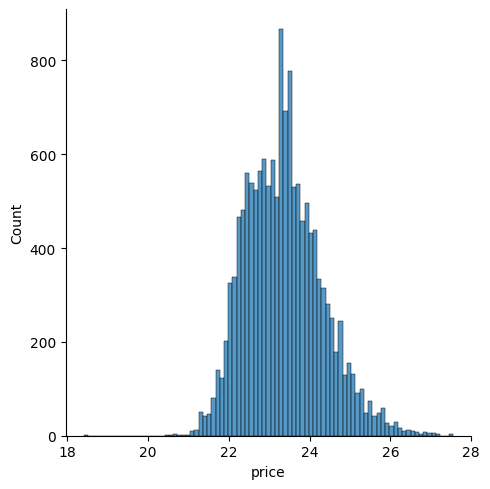

In [11]:
sns.displot(np.log(data['price']))
data['log_price'] = np.log(data['price'])


In [12]:
clean_train_data = data.drop(['price', 'price_per_sqm', 'log_price'], axis=1)
clean_train_label = data['log_price']
train_data, train_label, test_data, test_label = train_test_split(clean_train_data, clean_train_label, test_size=0.2, random_state=42)

In [13]:
train_data

,pr_id,type_estate,district,posted_date,area,legal_document,interior,num_bedrooms,num_bathrooms,num_floors,entrance,frontage
13784,39833228,1,4,2024-05-13,55.0,2,1,5,5,5,10.0,6.0
1369,39835594,2,12,2024-05-13,30.0,2,3,3,4,5,10.0,6.0
740,39787482,2,26,2024-05-08,54.0,2,1,5,4,4,10.0,6.0
8401,38477510,0,4,2024-05-14,80.0,2,1,5,5,5,10.0,6.0
3509,39829557,2,23,2024-05-12,46.0,1,1,4,5,6,4.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5191,39777524,2,4,2024-05-07,48.8,2,1,5,5,5,10.0,4.1
13418,39827230,1,12,2024-05-12,100.0,2,0,3,3,3,12.0,4.5
5390,39821299,2,23,2024-05-11,36.0,2,3,4,4,5,3.0,3.4
860,39540606,2,8,2024-05-13,32.0,1,3,3,5,5,10.0,6.0
